# Demo: AdaBoost Classifier

*Fraida Fund*

In this demo, we will build and train our own AdaBoost classifier, in order to better understand how this algorithm works. (At the end, we’l look at the `sklearn` implementation of AdaBoost and note that its behavior is identical.)

This demo is based on the following blog post: [AdaBoost: Implementation and intuition](https://xavierbourretsicotte.github.io/AdaBoost.html)

Note: for non-demo purposes, you can use the `sklearn` implementation, `AdaBoostClassifier` ([reference](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)).

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import seaborn as sns

from sklearn.datasets import make_circles
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

## Generate data

First, we will generate and plot some “toy” data for a binary classification problem with class labels $-1, 1$.

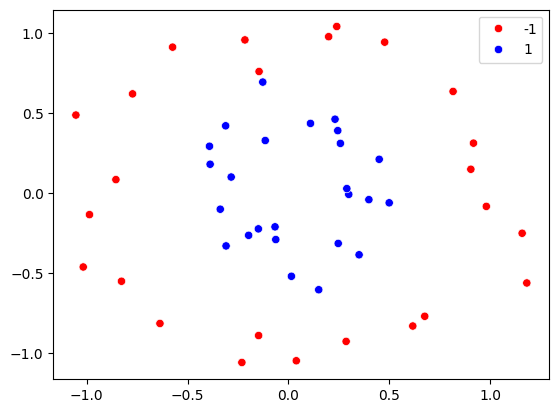

In [2]:
X, y = make_circles(noise=0.1, factor=0.4, n_samples=50, random_state=3)
y = y*2-1
x1 = X[:,0]
x2 = X[:,1]
sns.scatterplot(x=x1, y=x2, hue=y, palette={-1:'red', 1:'blue'});

## Select the base estimator and the number of estimators

The parameters of the base estimator and the number of base estimators are tuning parameters.

-   If this number of estimators (number of rounds of boosting) is small, the ensemble may have large bias.
-   If the base estimator is too complex (e.g. a deep tree), the ensemble may have high variance.

In [3]:
n_estimators = 15

dt = []
for i in range(n_estimators):
  dt.append(DecisionTreeClassifier(max_depth = 1))

## Initialize weights

In the first step of the algorithm, let $w_i = \frac{1}{N}$ for all $i$ in training set.

In [4]:
weights = np.repeat(1/len(y), repeats=len(y))
weights

array([0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02])

## Main loop

In each iteration, we:

-   Fit a decision stump (tree with depth 1) using a *weighted* version of the training data set, and get the predictions of the decision stump for the training data.
-   Compute weighted error:

$$err_m = \frac{\sum_{i=1}^N w_i 1(y_i \neq \hat{f}^m(x_i))}{\sum_{i=1}^N w_i}$$

-   Compute coefficient;

$$\alpha_m = \log \left( \frac{1-err_m}{err_m} \right)$$

-   Update weights:

$$w_{i+1} \leftarrow w_i e^{\alpha_m 1(y_i \neq \hat{f}^m(x_i))}$$

In [5]:
w      = np.zeros(shape=(n_estimators+1, len(weights)))
y_pred = np.zeros(shape=(n_estimators, len(y)))
err    = np.zeros(n_estimators)
alpha  = np.zeros(n_estimators)
acc    = np.zeros(n_estimators)

w[0] = weights

# loop over the number of base estimators
for m in range(n_estimators):
  # fit decision stump and get its predictions
  dt[m].fit(X, y, sample_weight=w[m])
  y_pred[m] = dt[m].predict(X)

  # compute accuracy of the stump
  # (not really required, just out of interest)
  acc[m] = accuracy_score(y, y_pred[m])

  # compute weighted error
  err[m] = sum(w[m]*(y_pred[m]!=y))/sum(w[m])

  # compute coefficient
  alpha[m] = np.log((1.0-err[m])/err[m])

  # update weights
  w[m+1] = w[m]*np.exp(alpha[m]*(y_pred[m]!=y))/np.sum(w[m])

## Ensemble prediction

The ensemble prediction is

$$\hat{f}(x) = \text{sign} \left[\sum_{m=1}^M \alpha_m \hat{f}^m(x)\right]$$

The sign of the ensemble output gives the predicted class.

The magnitude,

$$\text{abs} \left[\sum_{m=1}^M \alpha_m \hat{f}^m(x)\right]$$

indicates how confident the ensemble is in the prediction.

We will store the ensemble output from each stage of training, so that we can see how it changes. In general, however, it is only necessary to compute the ensemble output once, after the last iteration.

In [6]:
y_pred_en = np.zeros(shape=(n_estimators, len(y)))
acc_en = np.zeros(n_estimators)

for m in range(n_estimators):
  # compute ensemble prediction and its accuracy
  for i in range(m+1):
    y_pred_en[m] += alpha[i]*dt[i].predict(X)
  acc_en[m] = np.mean(y==np.sign(y_pred_en[m]))

## Visualization

We will create the following plots in each iteration:

1.  Plot of decision boundaries for the decision stump learned in this iteration.

-   Each region is shaded red or blue according to the prediction for the region, $\hat{y}_{R_k}$.
-   The intensity of the color of the region indicates the weighted proportion of samples in the region that belong to the predicted class. This is the estimated probability that a sample in this region belongs to the predicted class:

$$P(y=\hat{y}_{R_k} | x) = \frac{\sum_{i:x_i \in R_k} w_i 1(y_i=\hat{y}_{R_k})} {\sum_{i:x_i \in R_k} w_i} $$

-   Training points are plotted on top of the decision regions, with their color indicating their true class, and their size indicating their relative weight at the beginning of this iteration.

1.  Tree visualization for the decision stump learned in this iteration.

-   Each leaf node is shaded red or blue according to the prediction for the node. The intensity of the color is again

$$P(y=\hat{y}_{R_k} | x)$$

-   The `value=[a, b]` line in each node gives the weighted sum of samples in each class that appear at that node. (These weighted values are used to compute the GINI index and choose the feature and cutpoint to split on):

$$\sum_{i:x_i \in R_k} w_i 1(y_i=-1), \sum_{i:x_i \in R_k} w_i 1(y_i=1)$$

1.  Scatter plot of training points showing *change* in weight after this iteration.

-   The color of each point shows the ratio of its weight *after* this iteration, to its weight *before* this iteration. Any sample that is misclassified by the decision stump should have its weight increase by a factor of $e^{\alpha_m}$.

1.  Ensemble prediction after this iteration.

-   The color of each point shows its predicted class: $$\text{sign} \left[\sum_{m=1}^M \alpha_m \hat{f}^m(x)\right]$$

-   The size of each point shows the confidence of the prediction: $$\text{abs} \left[\sum_{m=1}^M \alpha_m \hat{f}^m(x)\right]$$

In [7]:
# utility function for plotting decision regions and scatter plot of data

def plot_decision_boundary(classifier, X, y, N = 10, scatter_weights = np.ones(len(y)) , ax = None ):

    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid( np.linspace(x_min, x_max, N), np.linspace(y_min, y_max, N))
    zz = np.array( [classifier.predict_proba(np.array([xi,yi]).reshape(1,-1))[:,1] for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )

    Z = zz.reshape(xx.shape)
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    # get current axis and plot
    if ax is None:
        ax = plt.gca()
    ax.contourf(xx, yy, Z, 2, cmap='RdBu', alpha=.5, vmin=0, vmax=1)
    ax.scatter(X[:,0],X[:,1], c = y, cmap = cm_bright, s = scatter_weights * 40)

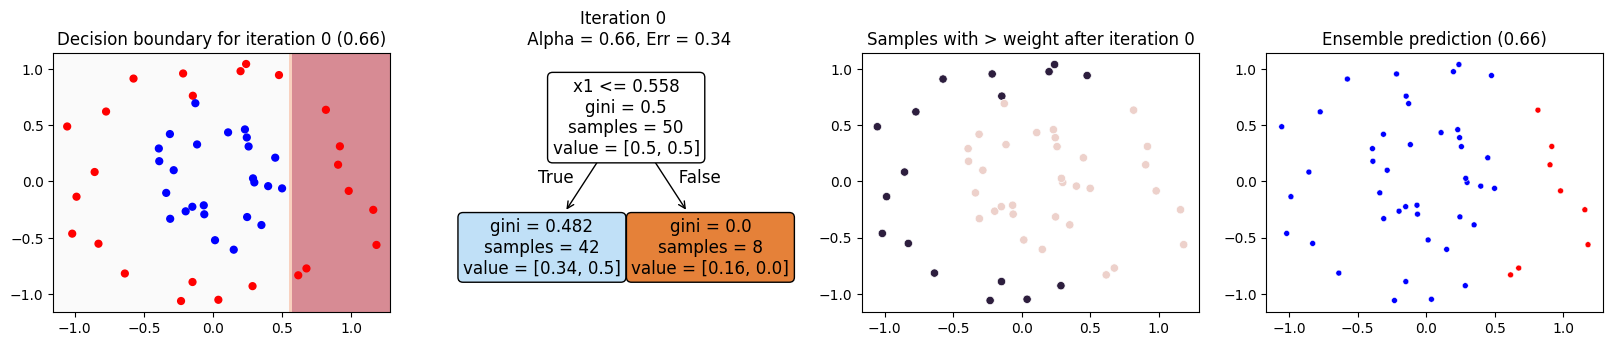

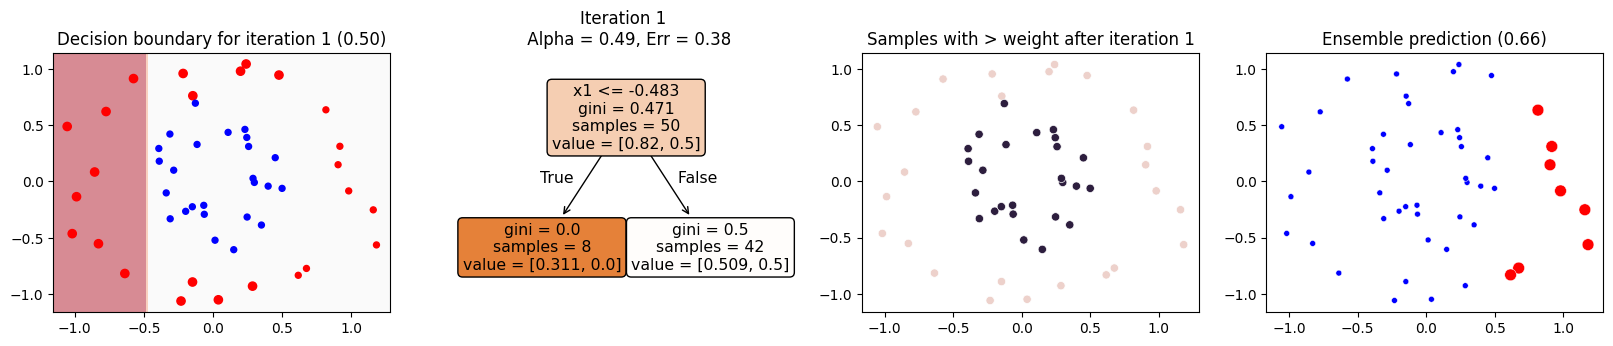

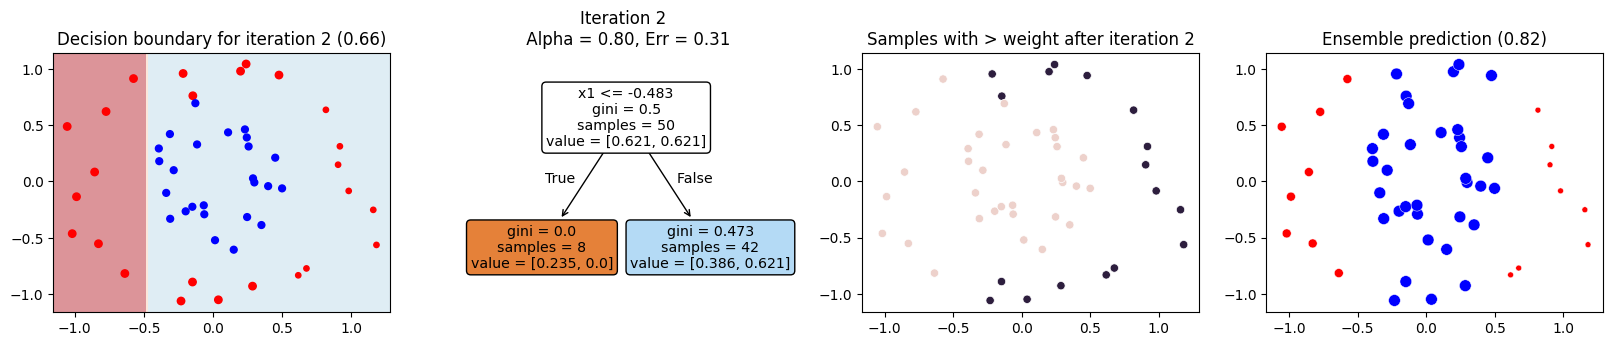

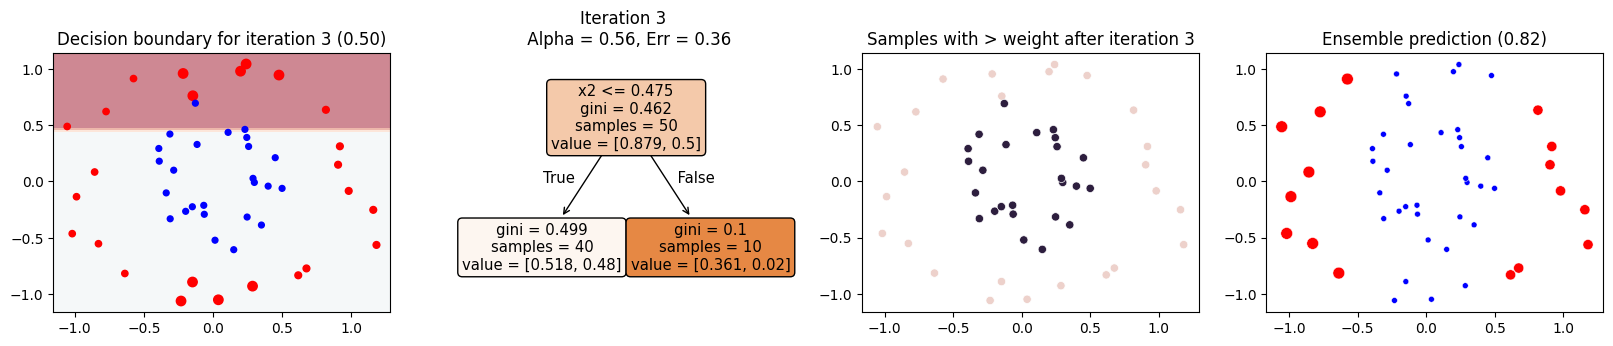

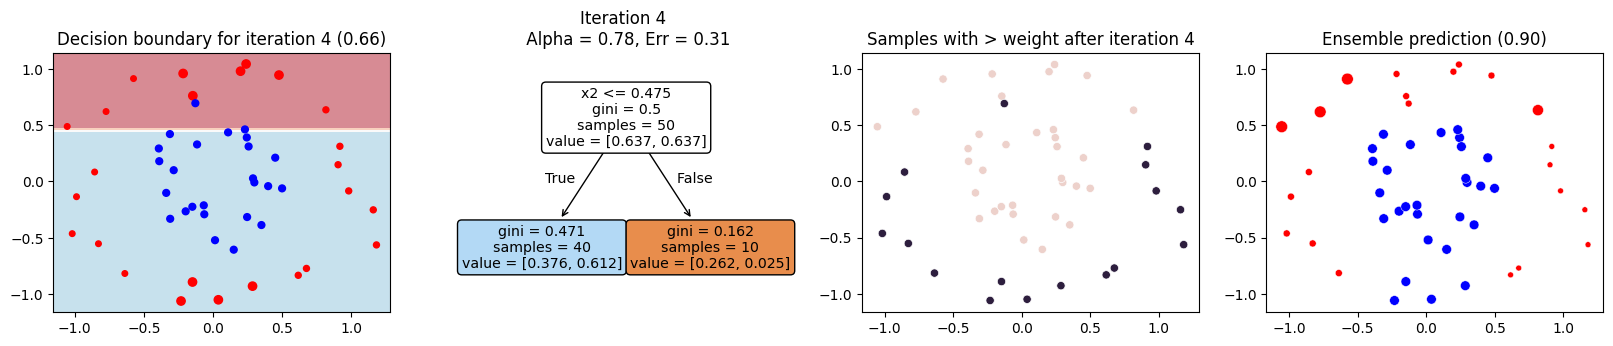

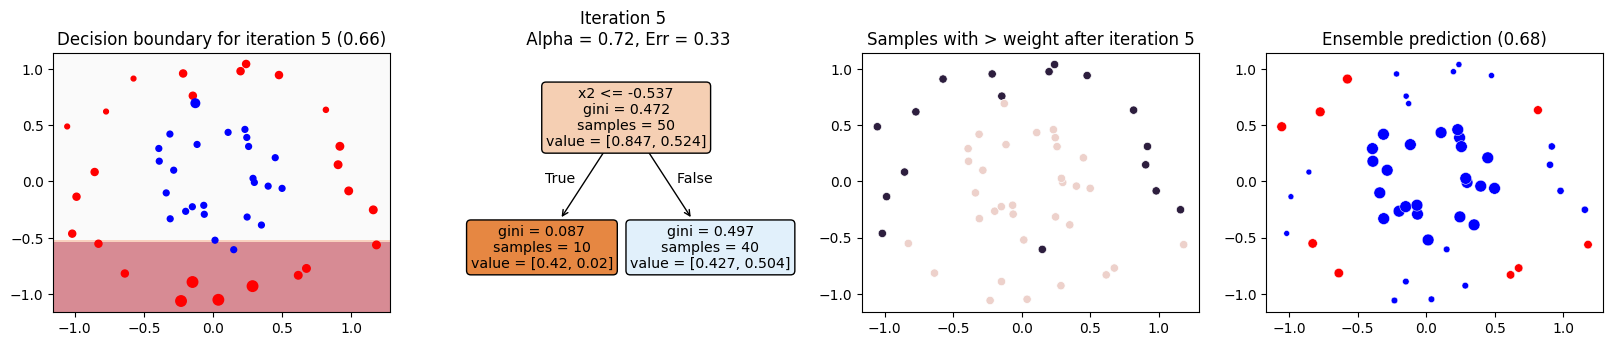

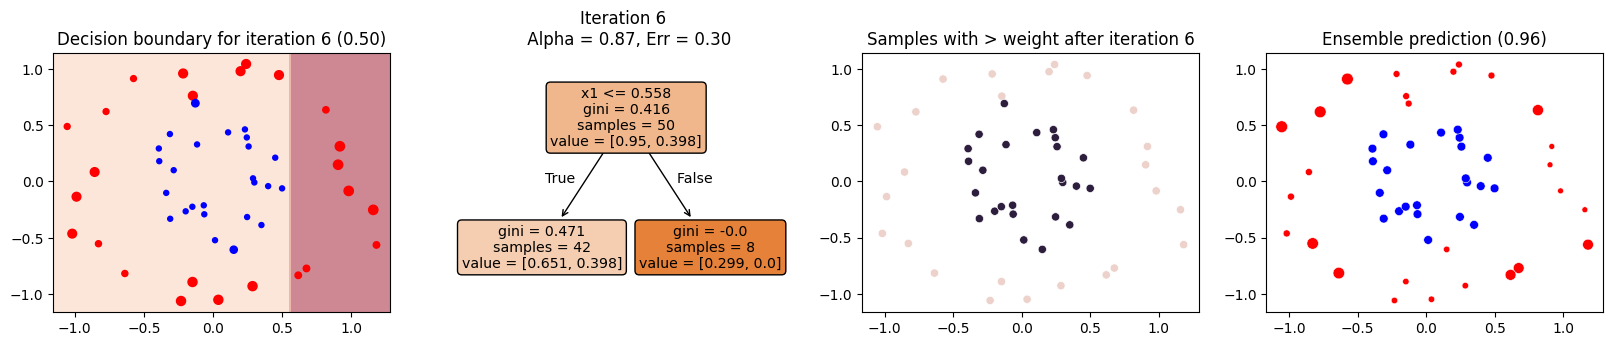

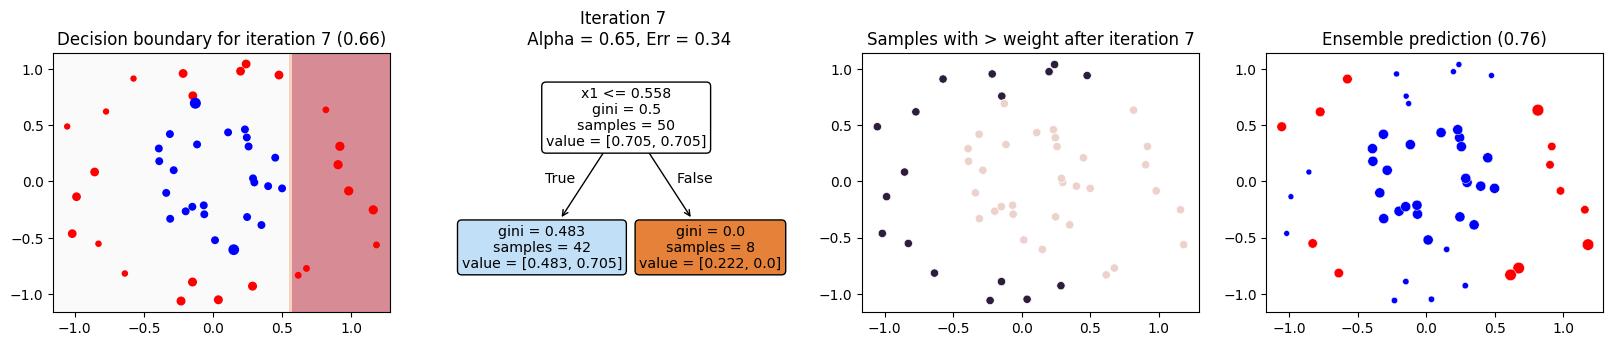

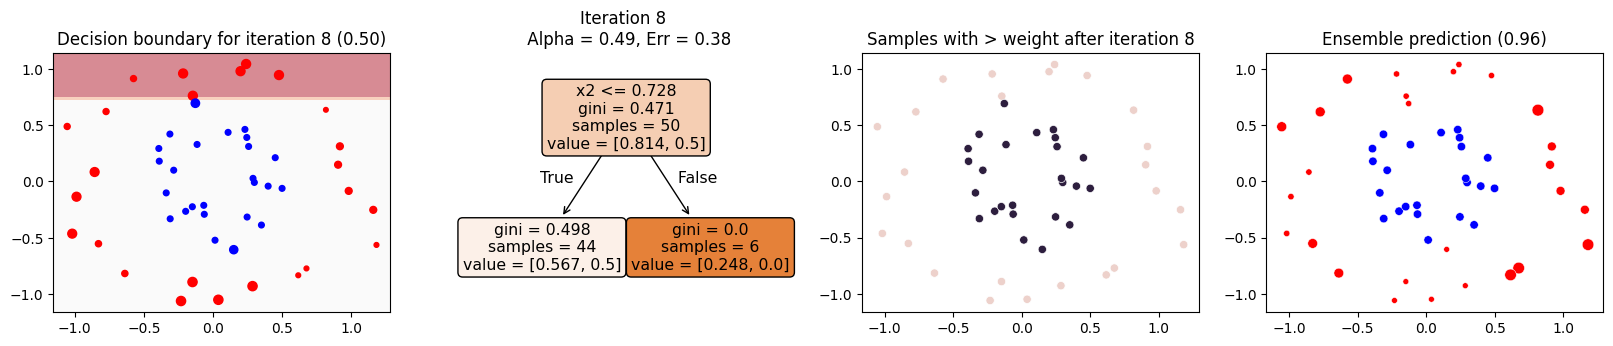

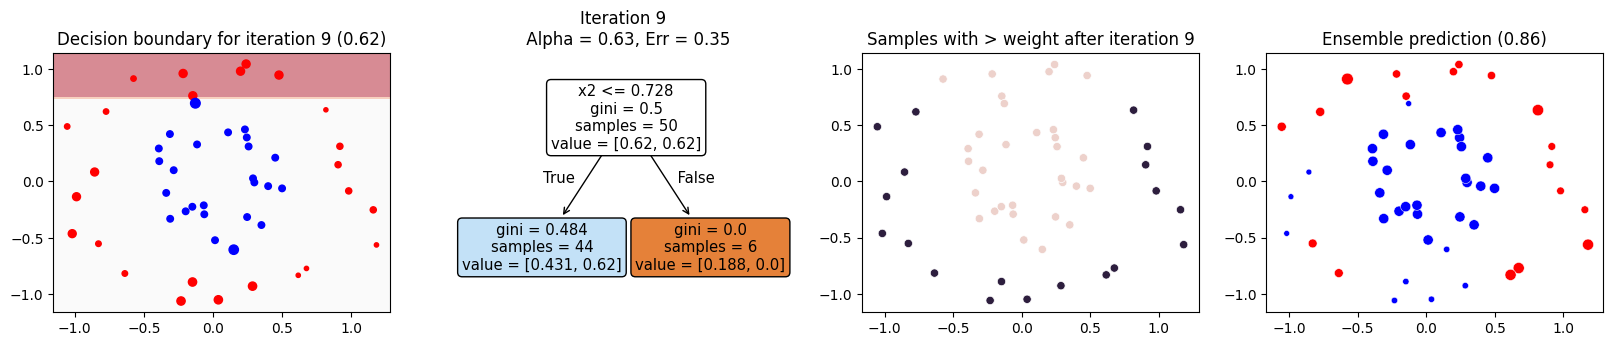

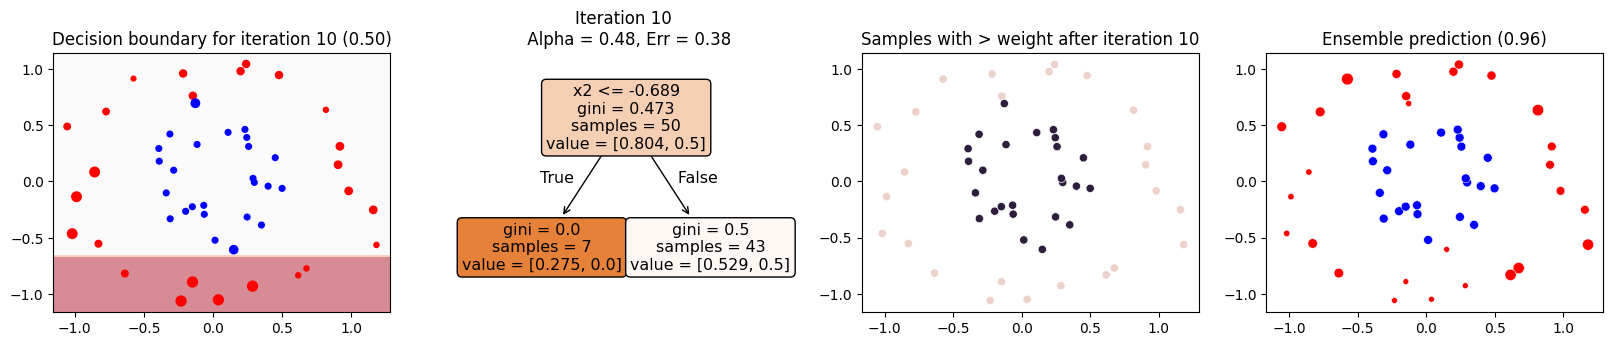

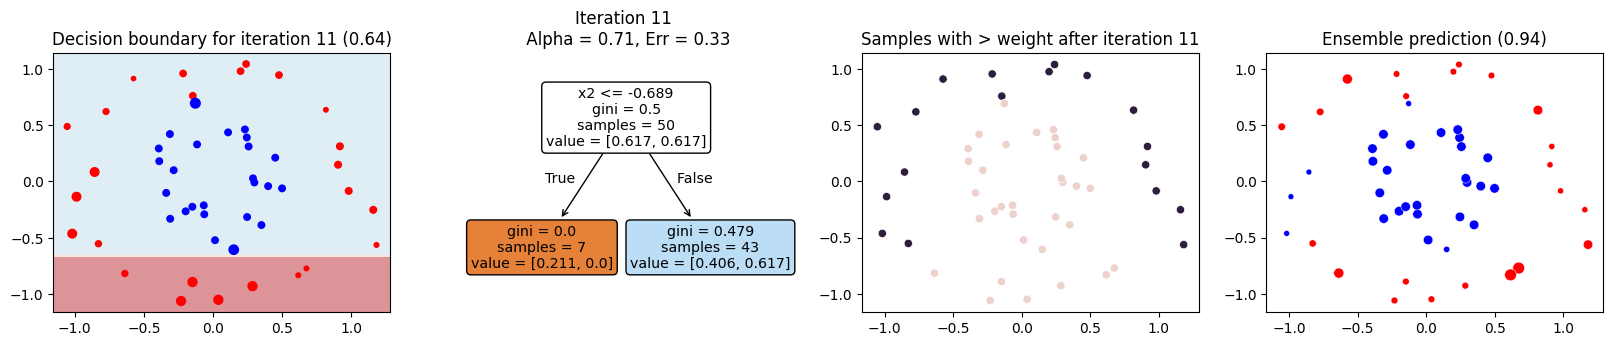

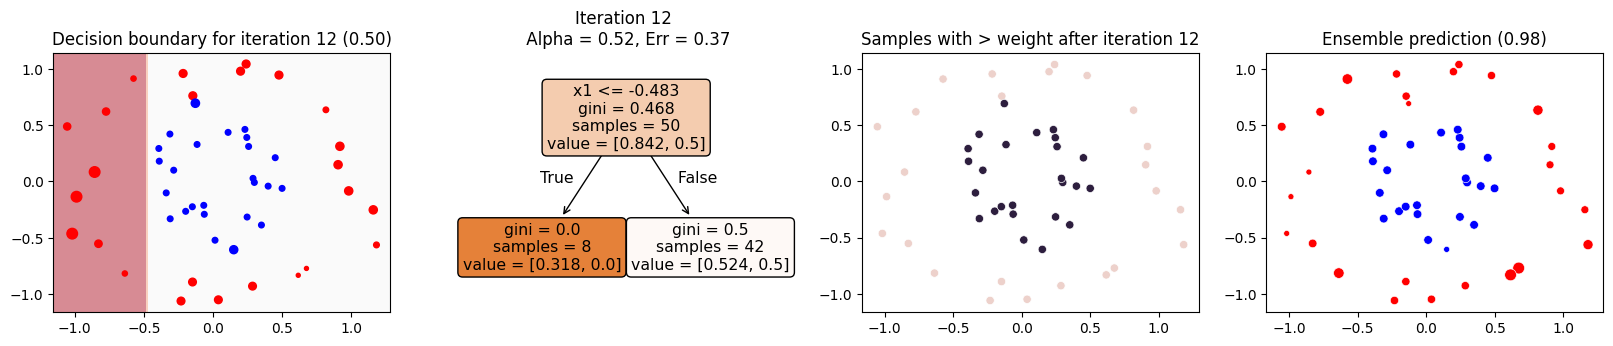

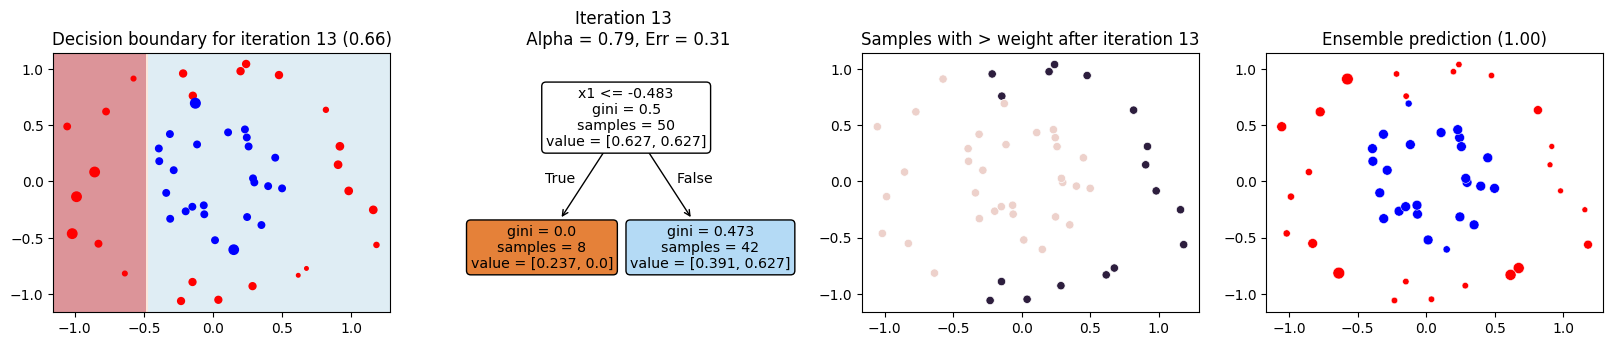

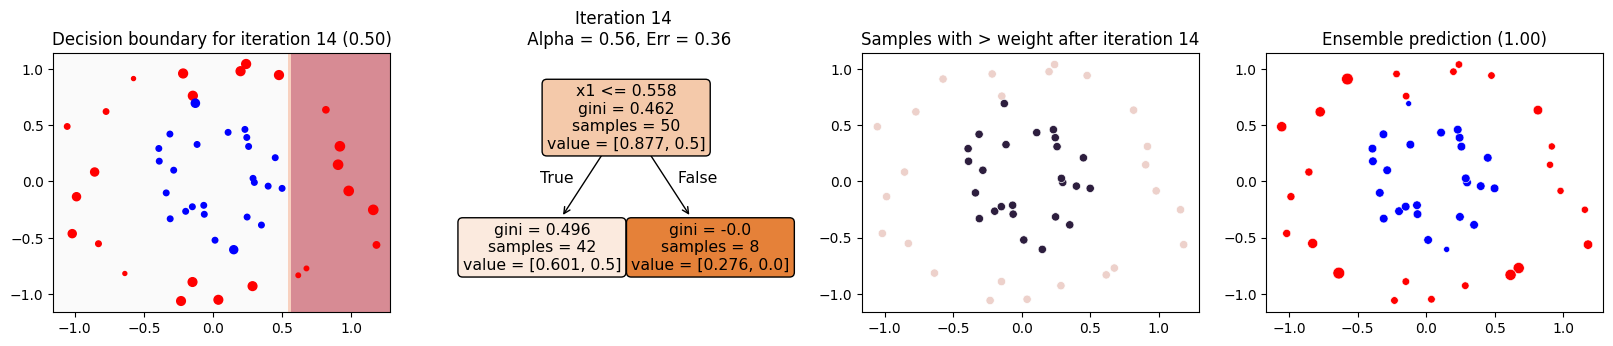

In [8]:
for m in range(n_estimators):
  # plot the decision stump and its decision regions
  # size of each point shows its relative weight
  fig = plt.figure(figsize = (20, 4*n_estimators));
  plt.subplot(n_estimators, 4, 1+m*4)
  plot_decision_boundary(dt[m], X,y,N = 50, scatter_weights =w[m]*30/sum(w[m]) )
  plt.title("Decision boundary for iteration %d (%0.2f)" % (m, acc[m]));

  # plot the tree diagram for the decision stump
  plt.subplot(n_estimators, 4, 2+m*4)
  plot_tree(dt[m], filled=True, rounded=True, feature_names=['x1', 'x2']);
  plt.title("Iteration %d \n Alpha = %0.2f, Err = %0.2f" % (m, alpha[m], err[m]));

  # plot the change in weights - show which points have increased weight
  # following this iteration
  plt.subplot(n_estimators, 4, 3+m*4)
  sns.scatterplot(x=x1, y=x2, hue=w[m+1]/w[m], legend=False);
  plt.title("Samples with > weight after iteration %d" % m);

  # plot ensemble prediction and its accuracy
  # size of point shows confidence in prediction
  plt.subplot(n_estimators, 4, 4+m*4)
  sns.scatterplot(x=x1, y=x2, hue=np.sign(y_pred_en[m]),
                  size=10*np.abs(y_pred_en[m]), legend=False,
                  palette={-1:'red', 0:'purple', 1:'blue'});
  plt.title("Ensemble prediction (%0.2f)" % acc_en[m]);

## `sklearn` implementation

In [9]:
from sklearn.ensemble import AdaBoostClassifier

clf_ab = AdaBoostClassifier(n_estimators = n_estimators, algorithm='SAMME',
                            estimator = DecisionTreeClassifier(max_depth=1))
clf_ab.fit(X, y)
accuracy_score(clf_ab.predict(X), y)

c:\Users\cj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


1.0

Note: in this implementation, we don’t have information about the weights at each step, so our visualization won’t include that.

In [10]:
y_pred_en_sk = np.zeros(shape=(n_estimators, len(y)))
acc_en_sk = np.zeros(n_estimators)
conf_en_sk = np.zeros(n_estimators)

for m, pred in enumerate(clf_ab.staged_predict(X)):
  y_pred_en_sk[m] = pred
  acc_en_sk[m] = np.mean(y==np.sign(y_pred_en_sk[m]))

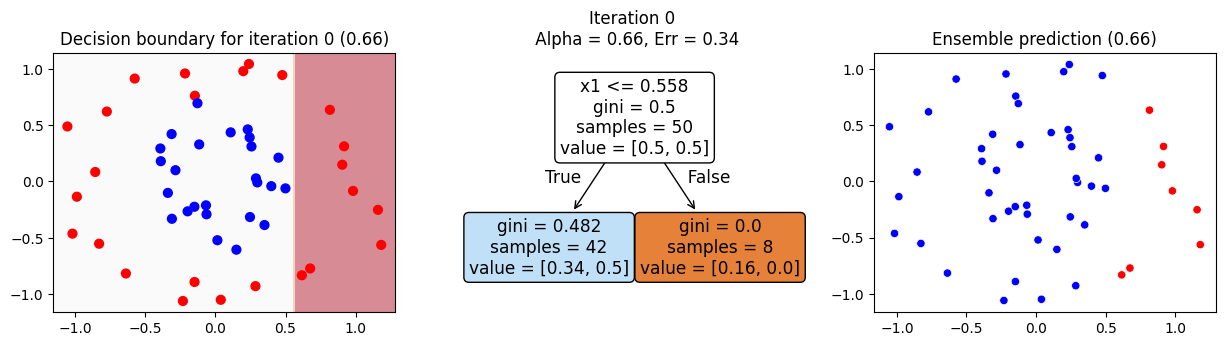

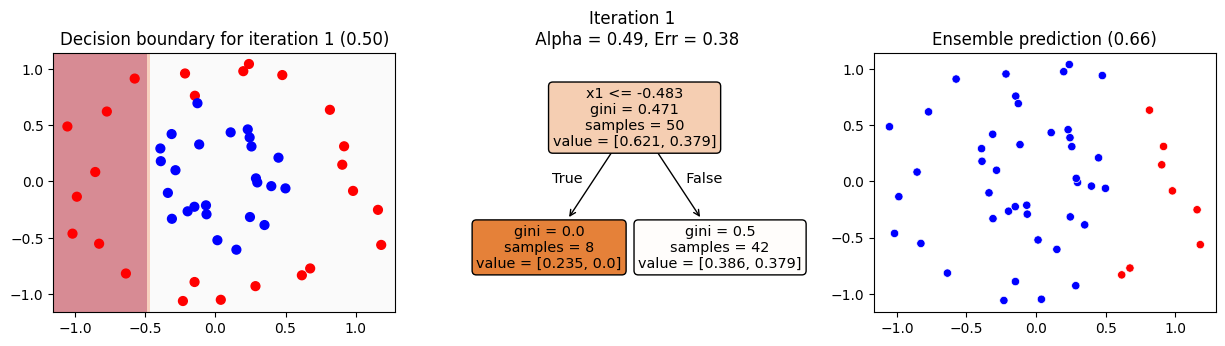

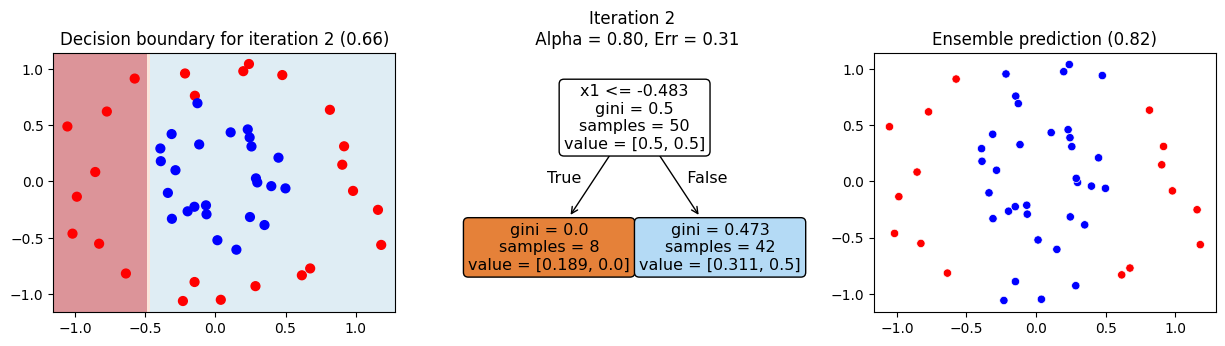

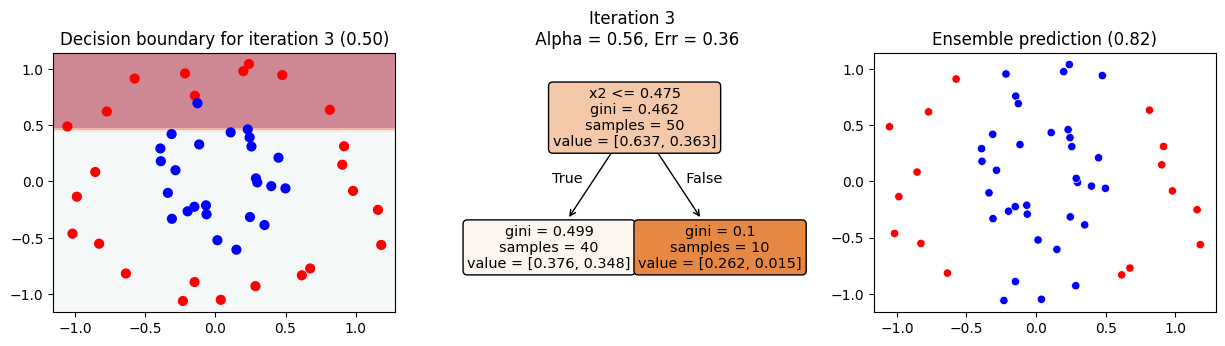

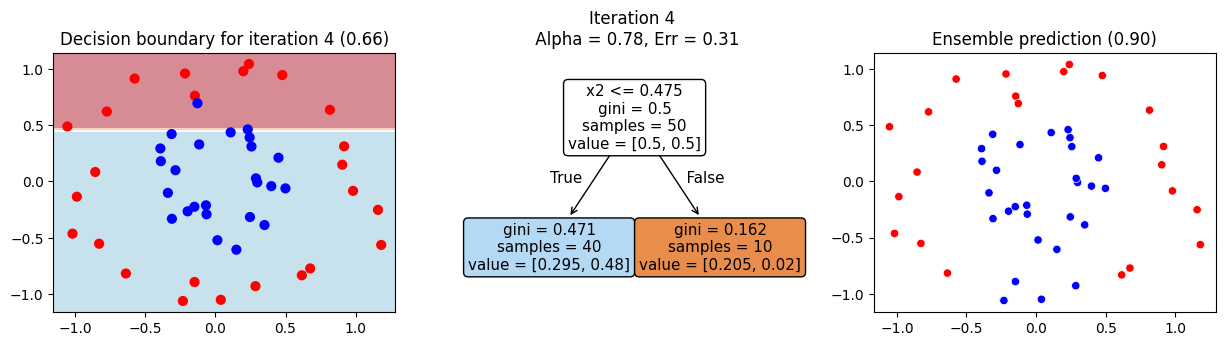

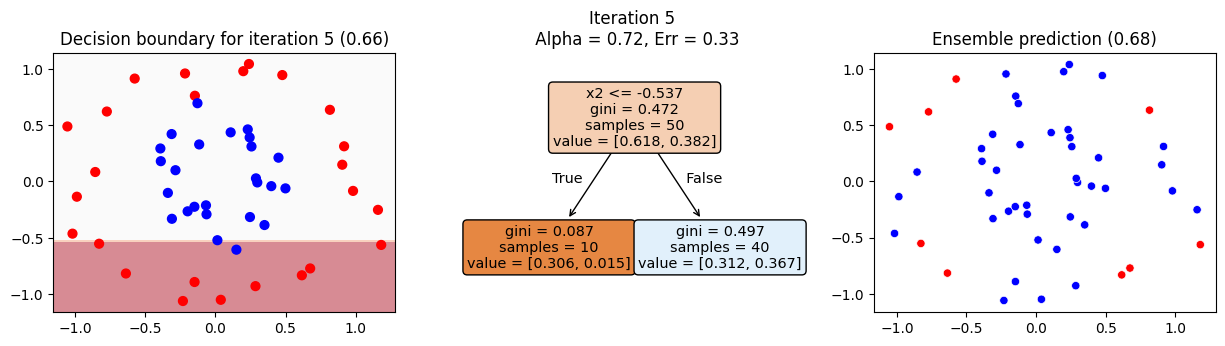

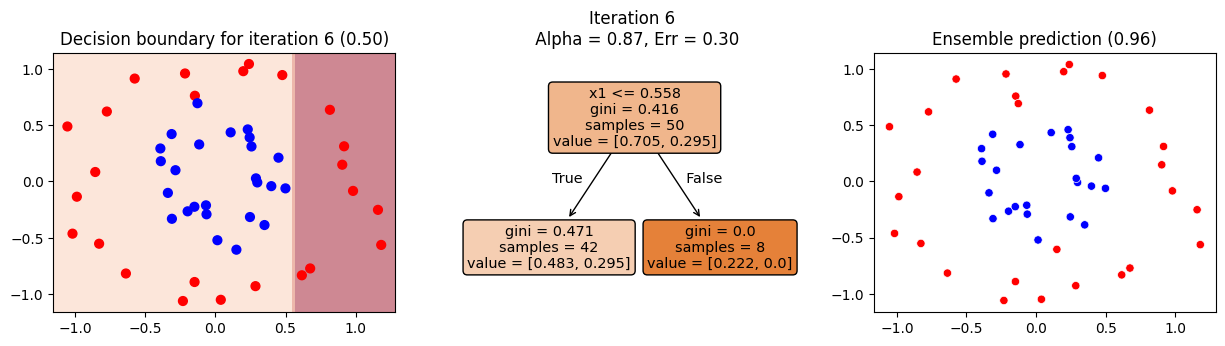

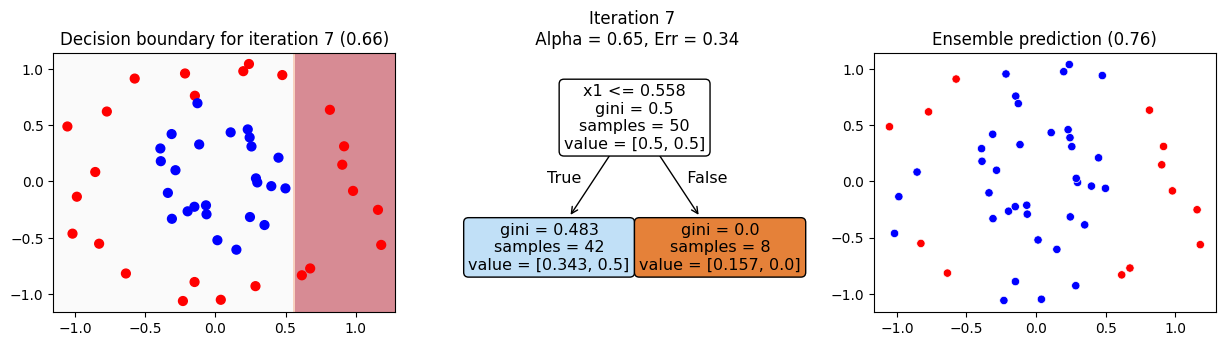

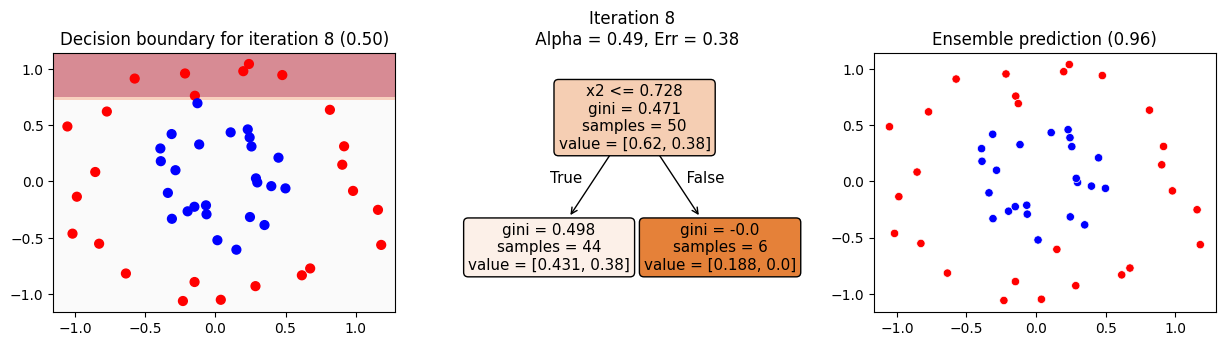

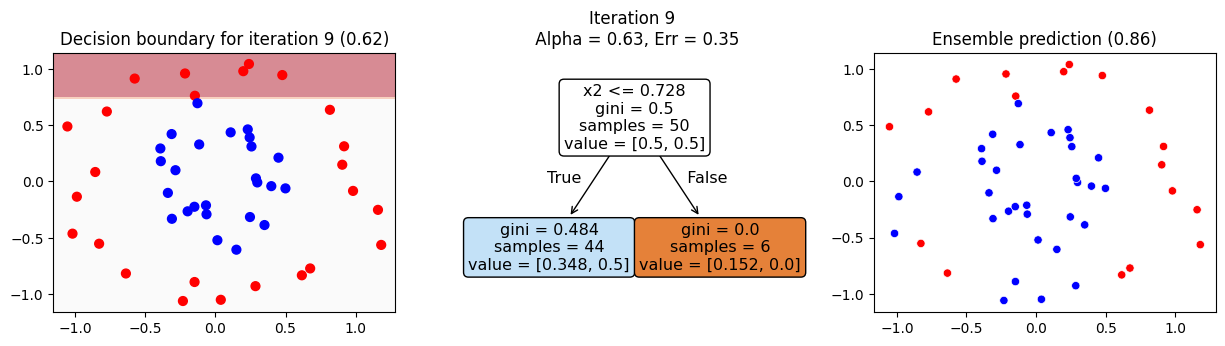

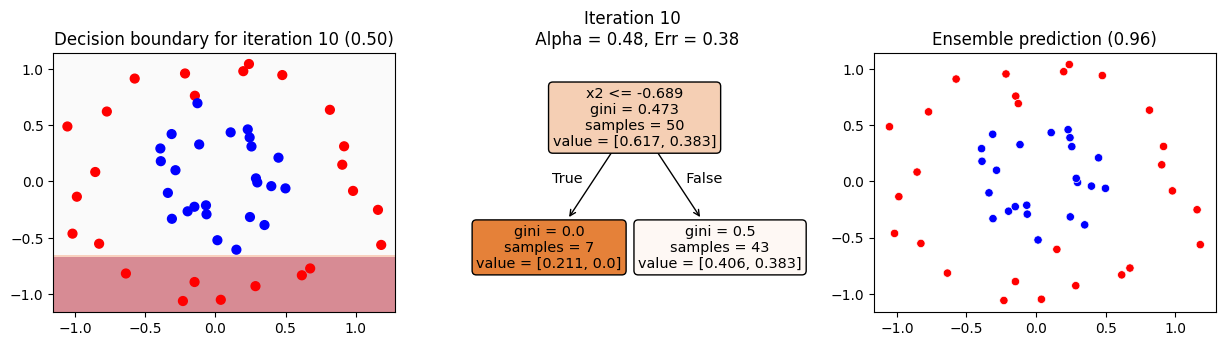

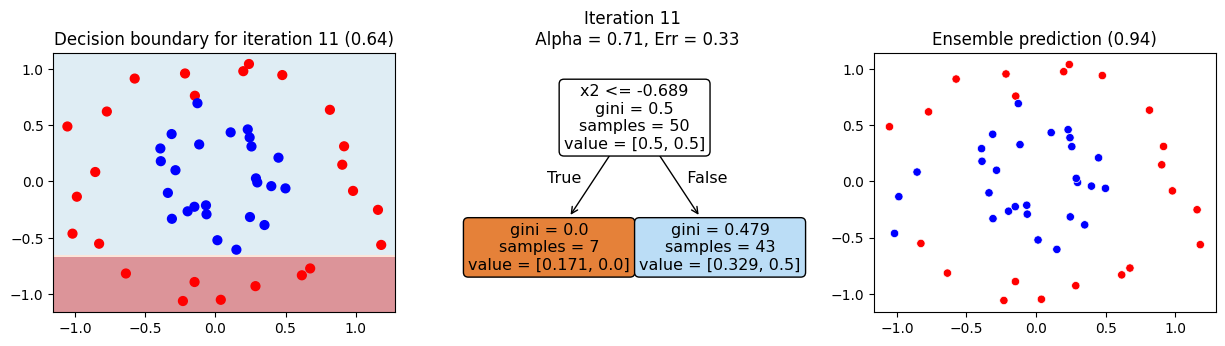

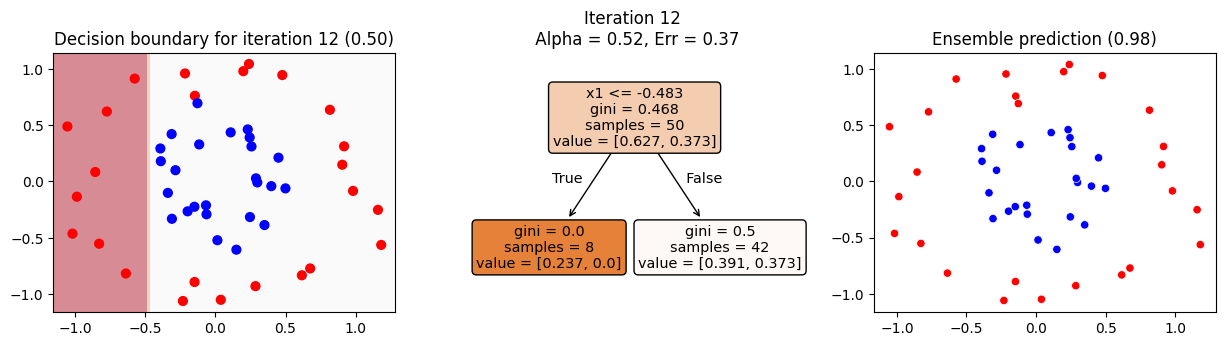

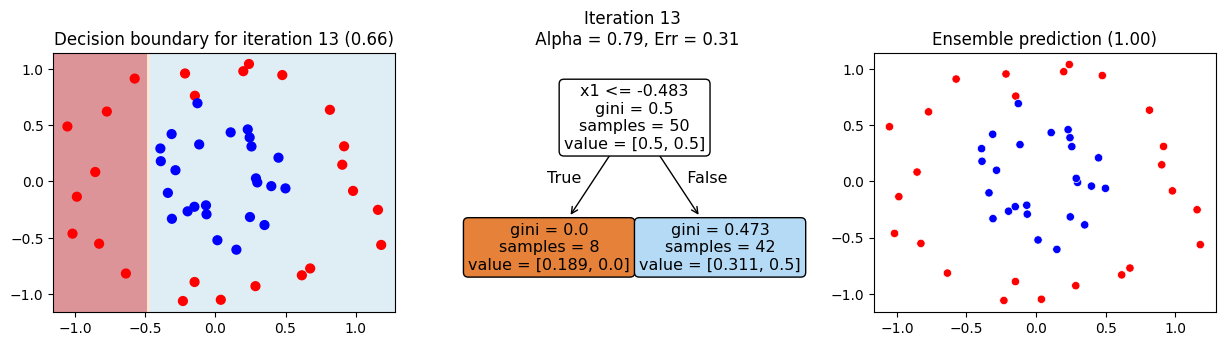

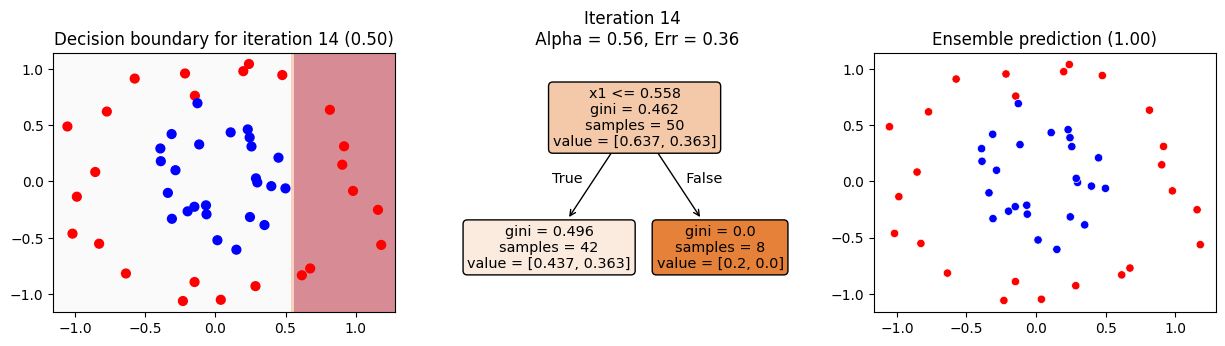

In [11]:
for m in range(n_estimators):
  # plot the decision stump and its decision regions
  # size of each point shows its relative weight
  fig = plt.figure(figsize = (15, 4*n_estimators));
  plt.subplot(n_estimators, 3, 1+m*3)
  plot_decision_boundary(clf_ab.estimators_[m], X,y,N = 50 )
  plt.title("Decision boundary for iteration %d (%0.2f)" %
            (m, accuracy_score(clf_ab.estimators_[m].predict(X), y)));

  # plot the tree diagram for the decision stump
  plt.subplot(n_estimators, 3, 2+m*3)
  plot_tree(clf_ab.estimators_[m], filled=True, rounded=True, feature_names=['x1', 'x2']);
  plt.title("Iteration %d \n Alpha = %0.2f, Err = %0.2f" %
            (m, clf_ab.estimator_weights_[m], clf_ab.estimator_errors_[m]));

  # plot ensemble prediction and its accuracy
  # size of point shows confidence in prediction
  plt.subplot(n_estimators, 3, 3+m*3)
  sns.scatterplot(x=x1, y=x2, hue=np.sign(y_pred_en_sk[m]),
                  legend=False,
                  palette={-1:'red', 0:'purple', 1:'blue'});
  plt.title("Ensemble prediction (%0.2f)" % acc_en_sk[m]);

The overall decision boundary looks like this:

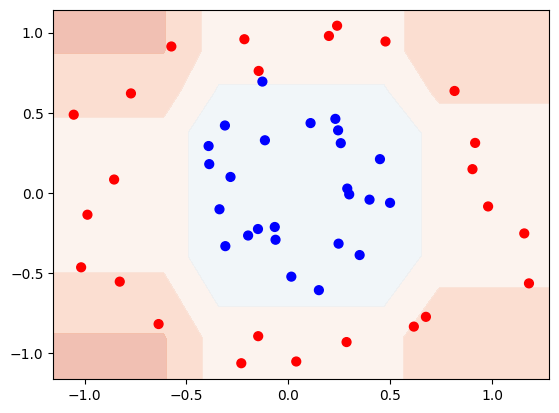

In [12]:
plot_decision_boundary(clf_ab, X, y)